In [1]:
#importing all of our required libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
#Now we need to import our data set of images and assign new names to our arrays
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_images = x_train
train_lables = y_train
test_images = x_test
test_lables = y_test

In [9]:
#checking that everything imported rightt
print (train_images.shape)
train_lables


(60000, 28, 28)


array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

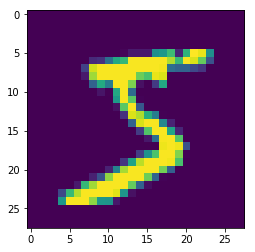

In [11]:
#taking a look at the first image in our data set
plt.imshow(train_images[0])

In [22]:
#Now going to resize every image so that the pixel ammounts is between 0 and 1
train_images.max()
train_images = train_images / 255.0
test_images = test_images / 255.0

In [23]:
#This is basically an optimizer that impliments the adam algorithm
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
opt = keras.optimizers.Adam(lr=0.0005,beta_1=0.5)

In [38]:
#Now we are going to build the generator. This is going to consist of two hidden layers and leaky relus. 
#We also need to define npar as shown bellow
npar = 100 #number of standard normal deviates to feed to generator input

generator = keras.Sequential([
    keras.layers.Dense(256, input_dim=npar, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(1024),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(784, activation="sigmoid")
])
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 784)               803600    
Total para

Now we are going to go ahead and make the discimnator. This time it will consist of an input layer of the images that the generator has generated, so 784, except it will be resized up to 1024. Then we will have two hidden sets of layers that include a leakyrelu, dropout layer and dense layer. The ouput layer gets narrowed down to 1 node, which is a represnetation of its confidence in whether the image is real or fake.

In [41]:
discriminator = keras.Sequential([
    keras.layers.Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
discriminator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
__________

In [42]:
discriminator.trainable = False
gi = keras.layers.Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = keras.Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=opt)

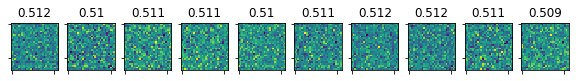

In [49]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,28,28),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
#o_d = "gen_models"
#if os.path.exists(o_d):
#    shutil.rmtree(o_d)

234


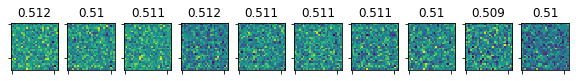

ValueError: all the input arrays must have same number of dimensions

In [52]:
batch_size = 256
batch_count = int(train_images.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
for e in range(1,400):
    for bc in range(batch_count):
        noise = np.random.randn(batch_size,npar)
        tr_im_batch = train_images[np.random.randint(0,train_images.shape[0],size=batch_size)]
        gen_im = generator.predict(noise)
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels...
        tr_im_lab = np.zeros(tr_im_batch.shape[0])
        tr_im_lab[:batch_size] = np.random.uniform(0.9,1.0,size=batch_size)
        tr_im_lab[batch_size:] = np.random.uniform(0.0,0.1,size=batch_size)
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise,tr_img_lab)
        print(e,bc,dloss,gloss,end="\r")
    if e % 5 == 0:
        
        plot_gen()
        plt.show()
        generator.save(os.path.join("gen_{0}.h5").format(e))
        
    
    